<a href="https://colab.research.google.com/github/Mokshitha09/Plant-disease-detection/blob/main/Plant_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.70G/2.70G [00:25<00:00, 115MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Define dataset path
train_dir = '/root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
test_dir = '/root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

# Image size and batch size
IMG_SIZE = 64  # Smaller size for faster training
BATCH_SIZE = 32

# Data Augmentation and Normalization
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255,  # Normalize images
    validation_split=0.1  # Split training into train/validation
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 63282 images belonging to 38 classes.
Found 7013 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [ ]:
# Build the CNN model
model = Sequential()

# First convolutional block
model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

# Second convolutional block
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

# Third convolutional block
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

# Flattening layer
model.add(Flatten())

# Fully connected layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))  # Dropout to prevent overfitting

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# Output layer (38 classes)
model.add(Dense(38, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for stable training
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks to optimize training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_cnn_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')  # Updated format

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3,
    callbacks=[early_stopping, model_checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 964s 485ms/step - accuracy: 0.2788 - loss: 2.7230 - val_accuracy: 0.6638 - val_loss: 1.1467
Epoch 2/3
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 943s 476ms/step - accuracy: 0.6141 - loss: 1.3308 - val_accuracy: 0.7978 - val_loss: 0.6762
Epoch 3/3
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 951s 481ms/step - accuracy: 0.7199 - loss: 0.9422 - val_accuracy: 0.8225 - val_loss: 0.5886


In [ ]:
# Load the best saved model
model.load_weights('best_cnn_model.keras')

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

550/550 ━━━━━━━━━━━━━━━━━━━━ 66s 120ms/step - accuracy: 0.6512 - loss: 1.2875
Test Accuracy: 0.68


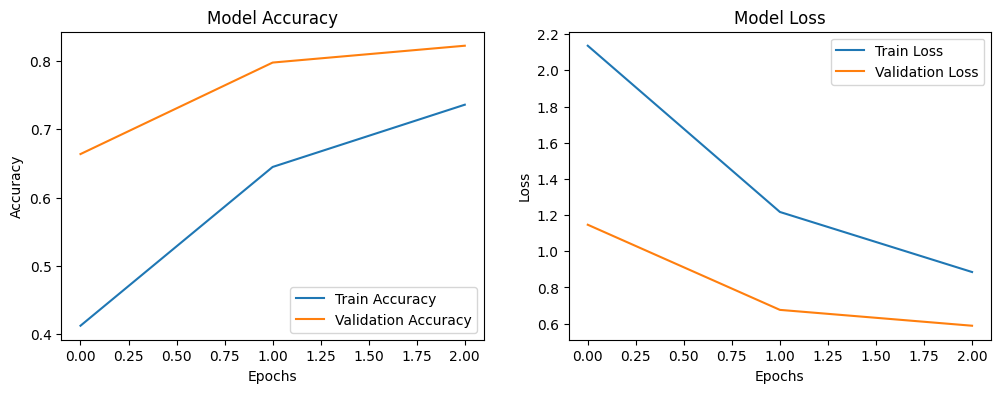

In [ ]:
# Plot training history
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

550/550 ━━━━━━━━━━━━━━━━━━━━ 68s 123ms/step


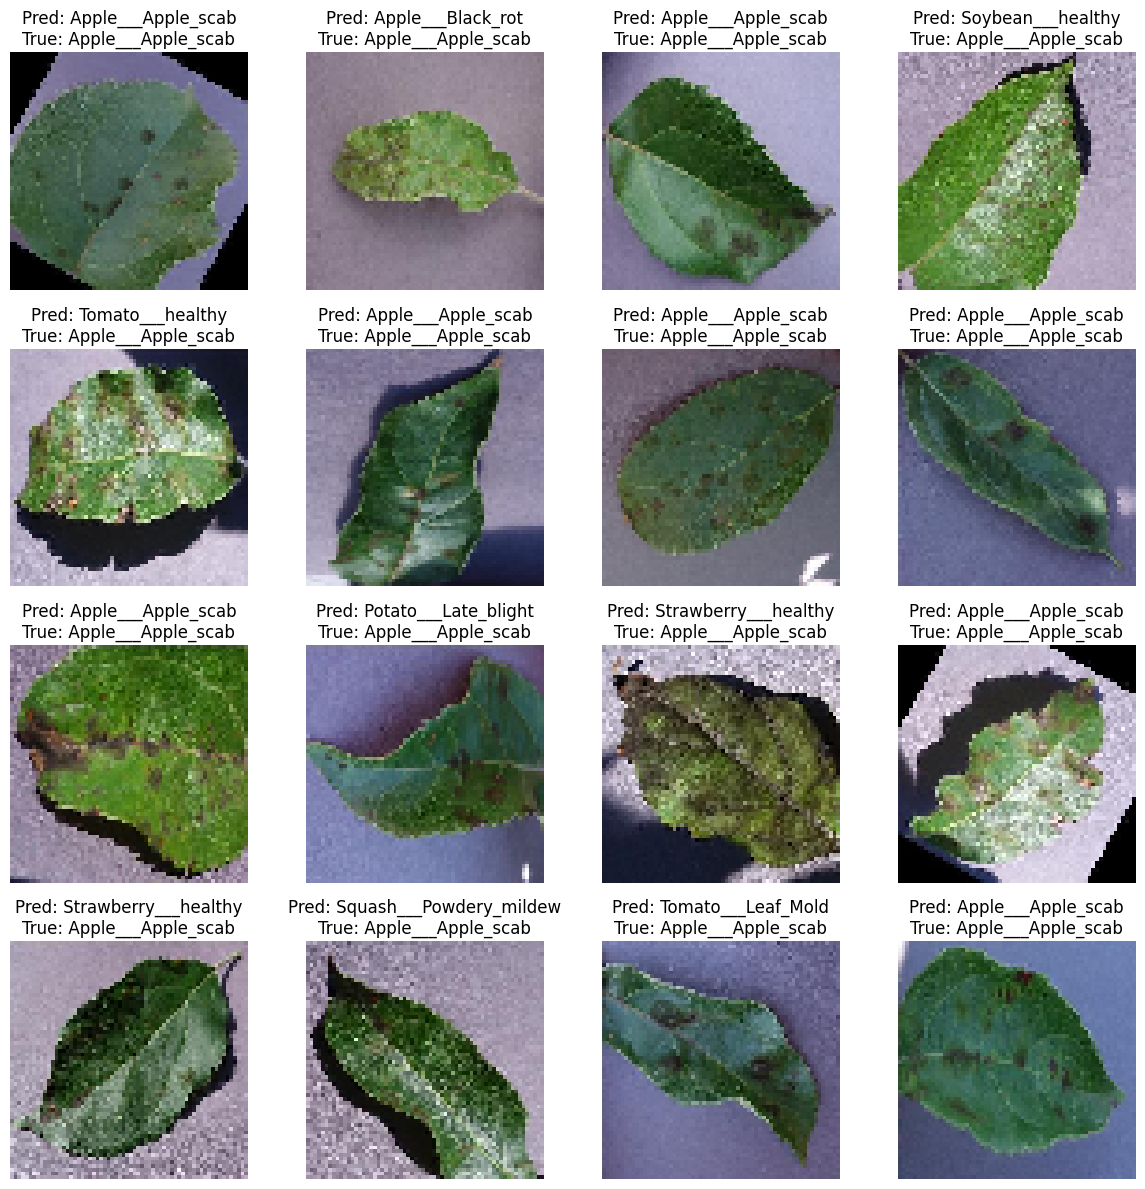

In [ ]:
# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Display sample predictions
import random
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()
for i in range(16):
    img, label = test_generator[i]
    img_idx = random.randint(0, img.shape[0] - 1)
    axes[i].imshow(img[img_idx])
    axes[i].set_title(f"Pred: {class_labels[predicted_classes[i]]}\nTrue: {class_labels[np.argmax(label[img_idx])]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
test_generator.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Blueberry___healthy': 4,
 'Cherry_(including_sour)___Powdery_mildew': 5,
 'Cherry_(including_sour)___healthy': 6,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7,
 'Corn_(maize)___Common_rust_': 8,
 'Corn_(maize)___Northern_Leaf_Blight': 9,
 'Corn_(maize)___healthy': 10,
 'Grape___Black_rot': 11,
 'Grape___Esca_(Black_Measles)': 12,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13,
 'Grape___healthy': 14,
 'Orange___Haunglongbing_(Citrus_greening)': 15,
 'Peach___Bacterial_spot': 16,
 'Peach___healthy': 17,
 'Pepper,_bell___Bacterial_spot': 18,
 'Pepper,_bell___healthy': 19,
 'Potato___Early_blight': 20,
 'Potato___Late_blight': 21,
 'Potato___healthy': 22,
 'Raspberry___healthy': 23,
 'Soybean___healthy': 24,
 'Squash___Powdery_mildew': 25,
 'Strawberry___Leaf_scorch': 26,
 'Strawberry___healthy': 27,
 'Tomato___Bacterial_spot': 28,
 'Tomato___Early_blight': 29,
 'Toma

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for stable training
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]  # Added Precision and Recall
)


In [ ]:
model_evaluate = model.evaluate(test_generator)
print("loss:", model_evaluate[0])
print("accuracy:", model_evaluate[1])
print("precision:", model_evaluate[2])
print("recall:", model_evaluate[3])


In [ ]:
# save the model
model.save('best_cnn_model.keras')

In [ ]:
def predict_image(image_path):
    from tensorflow import keras # Import keras from tensorflow
    from tensorflow.keras.preprocessing.image import load_img, img_to_array # import load_img and img_to_array
    # Assuming 'img_size' is defined
    img_size = (64, 64)  # Replace with actual image size if different
    # Assuming train_data is accessible from the global scope
    # Replace train_data with train_generator if you used a generator for training
    global train_generator

    model = keras.models.load_model("best_cnn_model.keras")
    image = load_img(image_path, target_size=img_size)
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    class_labels = list(train_generator.class_indices.keys())
    predicted_class = class_labels[np.argmax(prediction)]
    print(f"Predicted Class: {predicted_class}")

In [ ]:
predict_image("Tomato.JPG")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Predicted Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus
